In [1]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


### 1. Exploratory Data Analysis

In [14]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("dataset")
img_as_jpg = list(path.glob(r"*/*.jpg"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],img_as_jpg))
glioma = file_count.count('glioma_tumor')
meningioma = file_count.count('meningioma_tumor')
no_tum = file_count.count('no_tumor')
pituitary = file_count.count('pituitary_tumor')

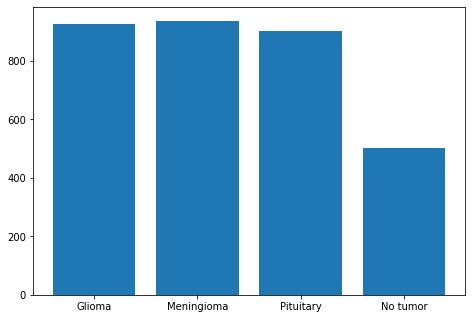

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Glioma','Meningioma', 'Pituitary', 'No tumor']
count_train = [glioma, meningioma, pituitary, no_tum]
ax.bar(labels, count_train)
plt.show()

In [16]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(3264, 2)


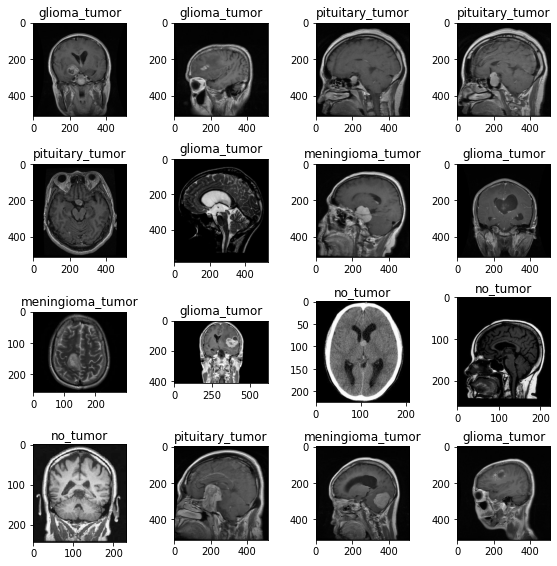

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1): 
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

## 2. Model

In [18]:
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=4,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("dataset", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy()) 
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 3264 files belonging to 4 classes.


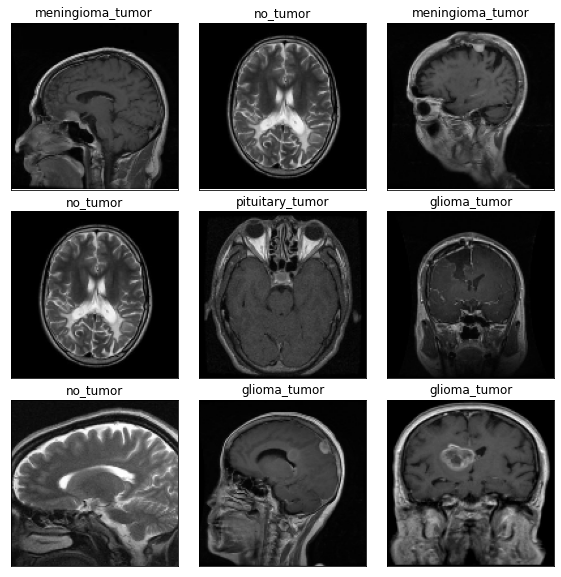

In [19]:
_ = plot_grid_ds(train_ds)

In [20]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [21]:
model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1


41/41 [==============================] - 31s 452ms/step - loss: 15.3410 - accuracy: 0.3528 - balanced_sparse_categorical_accuracy: 0.3434 - val_loss: 0.8688 - val_accuracy: 0.6781 - val_balanced_sparse_categorical_accuracy: 0.6767
Epoch 2/20
41/41 [==============================] - 16s 373ms/step - loss: 0.8284 - accuracy: 0.6622 - balanced_sparse_categorical_accuracy: 0.6548 - val_loss: 0.5905 - val_accuracy: 0.7703 - val_balanced_sparse_categorical_accuracy: 0.7773
Epoch 3/20
41/41 [==============================] - 17s 384ms/step - loss: 0.6735 - accuracy: 0.7227 - balanced_sparse_categorical_accuracy: 0.7319 - val_loss: 0.4606 - val_accuracy: 0.8422 - val_balanced_sparse_categorical_accuracy: 0.8450
Epoch 4/20
41/41 [==============================] - 17s 387ms/step - loss: 0.5178 - accuracy: 0.7963 - balanced_sparse_categorical_accuracy: 0.8064 - val_loss: 0.4900 - val_accuracy: 0.8109 - val_balanced_sparse_categorical_accuracy: 0.8265
Epoch 5/20
41/41 [============================

## 3. Results

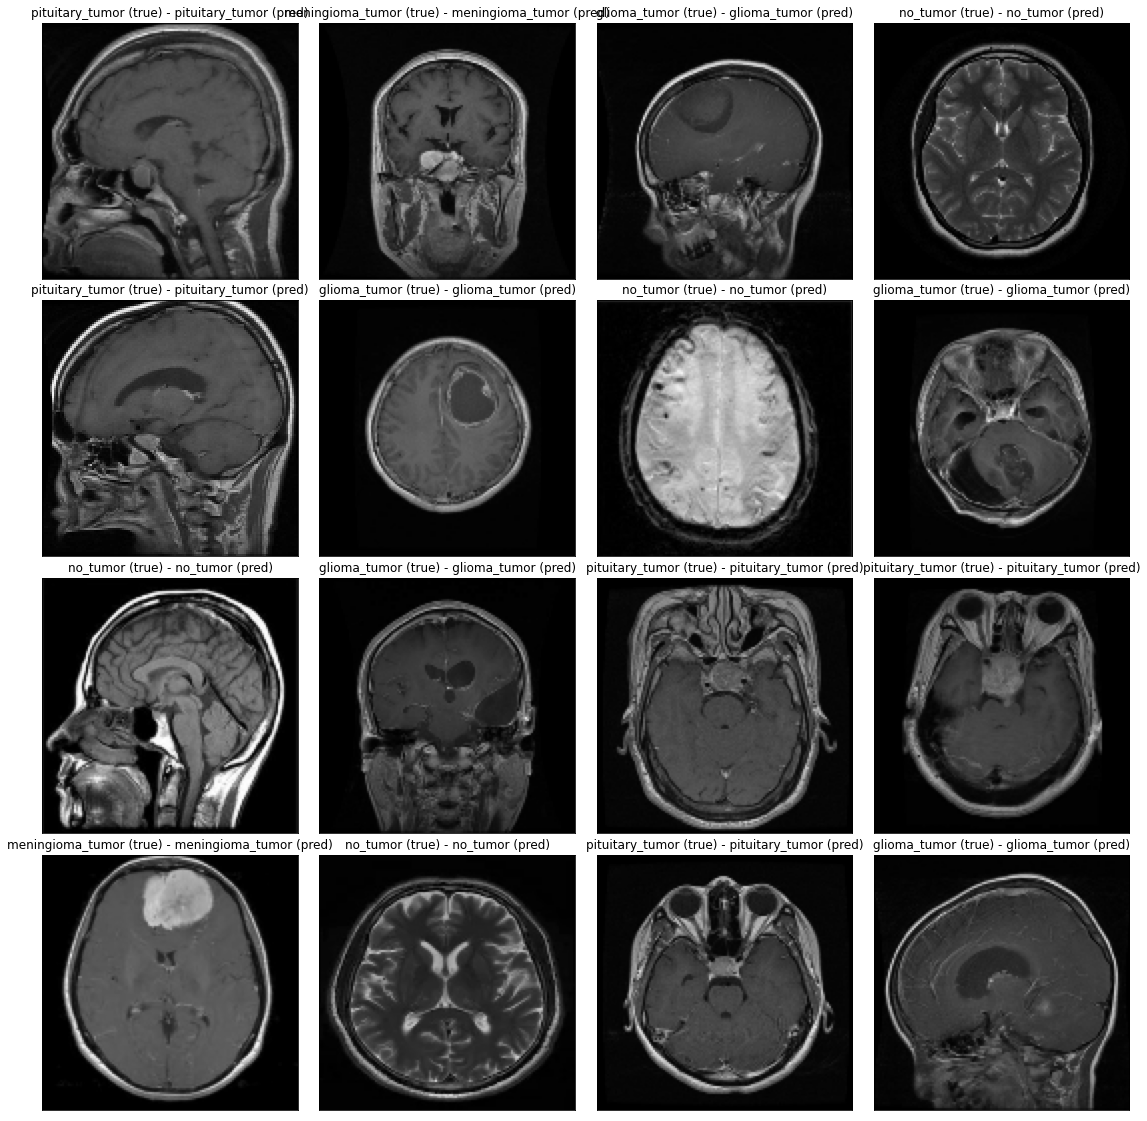

In [22]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [23]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

array([[171,   3,   2,   1],
       [  1, 159,   5,   2],
       [  1,   0, 105,   0],
       [  0,   0,   0, 190]])

In [24]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.977


In [25]:
model.save("models/ViT_on_10_epochs.model")

INFO:tensorflow:Assets written to: models/ViT_on_10_epochs.model/assets


INFO:tensorflow:Assets written to: models/ViT_on_10_epochs.model/assets
